In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import nibabel as nib
import numpy as np
import pandas as pd
import skimage.transform as skTrans
import matplotlib.pyplot as plt

current_directory = os.environ['HOME']

/home/rosengaard/miniforge3/envs/medsam3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Find number of steps

In [2]:
class CustomDataset(Dataset):
    def __init__(self, datapath):
        df_train=pd.read_csv(datapath)
        self.data = [] 
        for i in range(0, len(df_train)):
            self.data.append([(current_directory + '/' + df_train["DWI_path"][i]),
                              (current_directory + '/' + df_train["ADC_path"][i]),
                              (current_directory + '/' + df_train["b0"][i]),
                              (current_directory + '/' + df_train["Label_path"][i])])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        DWI_path, ADC_path, b0_path, Label_path = self.data[idx]

        ADC_vol = nib.load(ADC_path).get_fdata()
        ADC_tensor = self.resize_and_to_tensor(ADC_vol)

        DWI_vol = nib.load(DWI_path).get_fdata()
        DWI_vol = ((DWI_vol - DWI_vol.min()) / (DWI_vol.max() - DWI_vol.min()) * 255).astype(np.uint8)
        DWI_tensor = self.resize_and_to_tensor(DWI_vol)

        b0_vol = nib.load(b0_path).get_fdata()
        b0_tensor = self.resize_and_to_tensor(b0_vol)

        label_vol = nib.load(Label_path).get_fdata()
        label_tensor = self.resize_and_to_tensor(label_vol)

        scans_tensor = torch.cat([DWI_tensor, ADC_tensor, b0_tensor],0)
        return scans_tensor, label_tensor
    
    def resize_and_to_tensor(self, vol):
        vol_dim = (128, 128, 32) #volumes are resized to the same dimention
        vol = skTrans.resize(vol, vol_dim, order=1, preserve_range=True)
        vol_tensor = torch.from_numpy(vol).float() #Convert to tensor
        vol_tensor = vol_tensor.unsqueeze(0) #Add channel dim

        return vol_tensor
traindata_path = os.path.join(current_directory,"mri-infarct-segmentation/data/General_dataset/datasplit/train_data.csv")
trainDataset = CustomDataset(traindata_path)

In [5]:
nEpoch = 20
start_lr = 1e-6
end_lr = 0.0001
batchSize = 2

trainDataLoader = torch.utils.data.DataLoader(trainDataset,
                                              batch_size=batchSize,
                                              shuffle=True,
                                              num_workers = 0
                                              )

# Scheduler
def exp_lr_scheduler(start_lr, end_lr, num_iter):
    """Generates exponentially increasing learning rates."""
    factor = (end_lr / start_lr) ** (1/num_iter)
    return lambda x: start_lr * (factor ** x)

# Antal batches per epoch
num_batches = len(trainDataLoader)

# Totalt antal trin (batches):
total_steps = nEpoch * num_batches

# Scheduler funktion
lr_scheduler = exp_lr_scheduler(start_lr, end_lr, total_steps)

print('Total steps:',total_steps)
print(lr_scheduler(0)) # Start LR
print(lr_scheduler(total_steps)) # End LR

Total steps: 1500
1e-06
9.999999999999804e-05


# Check the FindLr cycle:

In [4]:
path = os.path.join(current_directory, 'mri-infarct-segmentation/Anders/V3/Unet_C3/JAG/Slurm/FindLr/Lr_Unet_C3.csv')
df = pd.read_csv(path)
lrs = []
losses = []
for i in range(0, len(df)):
    lrs.append([df["Lr"][i]])
    losses.append([df["Loss"][i]])

In [5]:
lrs = np.array(lrs[1:])
losses = np.array(losses[1:])
print(len(lrs))

298


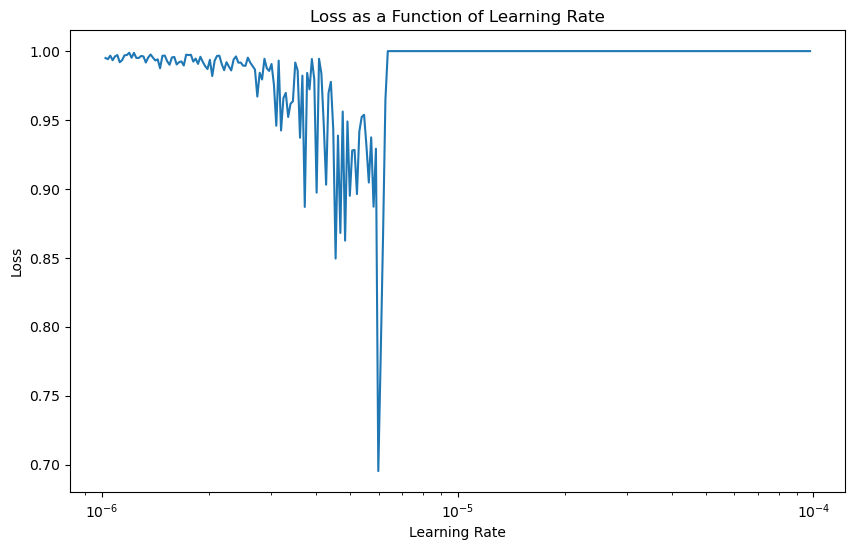

In [6]:
# Plotting af loss som en funktion af learning rate
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Loss as a Function of Learning Rate")
plt.show()

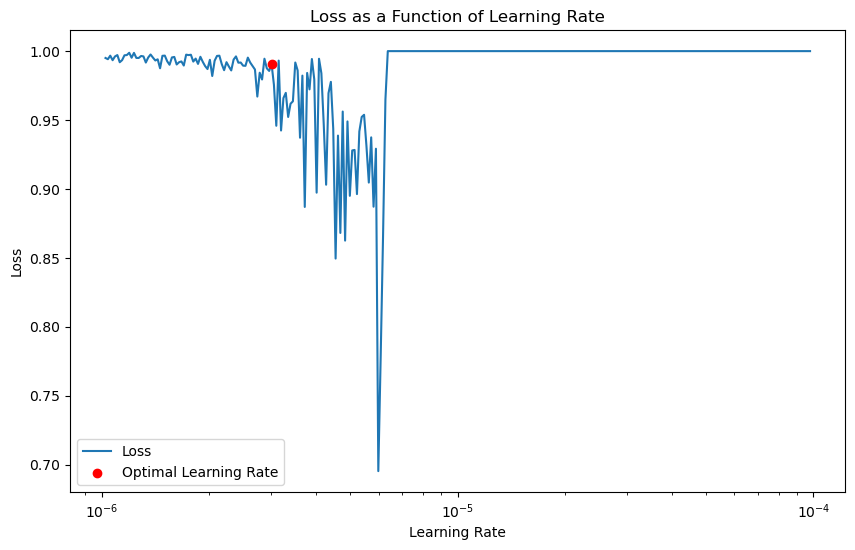

Optimal Learning Rate: [3.00149364e-06]


In [7]:
def find_optimal_lr(lrs, losses):
    # Beregner den numeriske afledte af loss mht. learning rate (dLoss/dLR):
    loss_grad = [losses[i] - losses[i-1] for i in range(1, len(losses))]
    
    # Finder indekset for det laveste punkt i gradienten (punktet repræsenterer stedet med den hurtigste nedgang i loss):
    min_grad_idx = loss_grad.index(min(loss_grad))
    
    # Vælger en learning rate lidt lavere end dette punkt for stabilitet:
    optimal_lr = lrs[max(0, min_grad_idx - 44)]

    # Find det tilsvarende tab for den optimale learning rate
    optimal_loss = losses[max(0, min_grad_idx - 44)]
    
    # Plot:
    plt.figure(figsize=(10, 6))
    plt.plot(lrs, losses, label="Loss")
    plt.scatter(optimal_lr, optimal_loss, color='red', label="Optimal Learning Rate", zorder=5)

    plt.xscale('log')
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.title("Loss as a Function of Learning Rate")
    plt.legend()
    plt.show()
    
    return optimal_lr

optimal_lr = find_optimal_lr(lrs, losses)
print(f"Optimal Learning Rate: {optimal_lr}")